# STEP 3: Social Media Analysis - NLP Analysis

## Description of the methodology
> * Analyze Snippet and Hashtags features with Wordcloud
* Pre-processing of "Snippet" feature
* Evaluation of text transformation and word embeding strategy
* Perform word embeding and visualize the it using t-SNE dimensionality reduction and conclusions
* Perform snippet embeding via averaging word embeding for each of them
* Visualize snippet embeding using t-SNE dimensionality reduction and conclusions
* Consolidate text embedding into a dataframe with numeric features engineering during the EDA + reduce/not reduced dimension NLP features
* **Warning**: It requires to download and save the reference file for the Word2vec processing in order to perform tasks in this Notebook
* Link to the dataset source: https://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms#

## Import librairies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.fftpack as sp
import matplotlib.pyplot as plt
from adjustText import adjust_text


import re

# t_NSE dimensionality reduction
from sklearn.manifold import TSNE

# NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import gensim
import gensim.parsing.preprocessing as gsp
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

import warnings
warnings.filterwarnings("ignore")

# Activate Seaborn style
sns.set()

## Load the file for analysis

In [2]:
# Importing the file and creating a dataframe
twitter_nlp = pd.read_csv(
    "masterdata_ml.csv",
    low_memory=False,
    skipinitialspace=True,
)  # , sep='\t'

In [3]:
# remove the Unnamed column
twitter_nlp.drop("Unnamed: 0", axis=1, inplace=True)
twitter_nlp.shape

(195880, 50)

In [4]:
twitter_nlp.head()

,Sentiment,Company_Clarivate,Company_Informa,Company_Pearson,Company_RELX Group,Company_Thomson Reuters,Company_Wolters Kluwer,Country 2_Argentina,Country 2_Australia,Country 2_Belgium,...,ALL_Impact,Log_TW_KredOutreach,Log_Nbreach,Log_TW_NbFollowers,Log_TW_NbFollowing,Log_TW_NbTweets,Snippet,TW_Hashtags,ALL_Author,TW_Account_Name
0,0,0,0,0,0,1,0,0,0,0,...,28,0.0,6.052089,4.043051,5.093750,7.409136,anniversary project timesquare thomson reuters...,2017btsfesta,titina_joner,tw account not identified
1,0,0,0,0,0,1,0,0,0,0,...,25,0.0,5.940171,3.295837,4.948760,8.307706,nearly canadians deport people illegally cross...,No TW hashtag,dasCameo1,tw account not identified
2,0,0,0,0,0,1,0,0,0,0,...,25,0.0,5.921578,3.135494,0.000000,12.286371,support associate thomson reuters carrollton i...,"indeed, jobs",lumpyspace_tst2,tw account not identified
3,0,0,0,0,0,1,0,0,0,0,...,64,0.0,7.832808,6.736967,5.043425,4.564348,mifidii compliance challenge mifidii ready ana...,"MiFIDII, TRRisk",mifidii,tw account not identified
4,0,0,1,0,0,0,0,0,0,0,...,41,0.0,6.408529,7.094235,7.222566,8.832150,challenges implementing insurance projects imp...,"infographic, iot",daviddefelipe,david de felipe


## Create a dataframe with text features only

In [5]:
nlp_1 = twitter_nlp[["Snippet", "TW_Hashtags"]]

In [6]:
nlp_1.head()

,Snippet,TW_Hashtags
0,anniversary project timesquare thomson reuters...,2017btsfesta
1,nearly canadians deport people illegally cross...,No TW hashtag
2,support associate thomson reuters carrollton i...,"indeed, jobs"
3,mifidii compliance challenge mifidii ready ana...,"MiFIDII, TRRisk"
4,challenges implementing insurance projects imp...,"infographic, iot"


## Analyze Snipet and hashtags with Wordcloud
>* The objective is to highlight some keywords at a high level 
* Wordcloud of tweet Snippet and hashtags is not very conclusive
* More complex processing would be required to visualize potentially some patterns or clusters

In [7]:
# Define the function to display wordcloud


def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color="white",
        max_words=1000,
        max_font_size=40,
        scale=3,
        random_state=1,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis("off")
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### Tweet snippet wordcloud

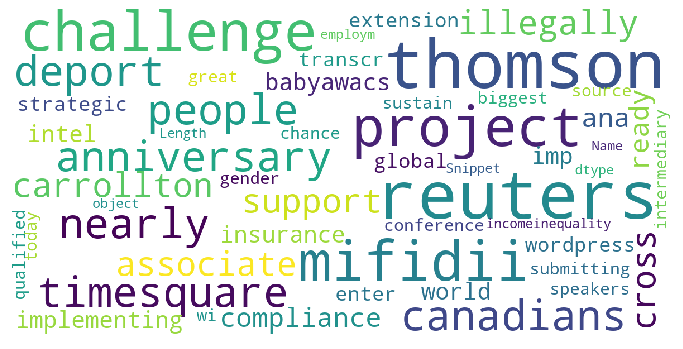

In [8]:
show_wordcloud(nlp_1["Snippet"])

### Tweet hastags wordcloud

In [9]:
# Select Hashtags without the No TW hashtag class (most common)
value_list = ["No TW hashtag"]

# Select rows without the 'No TW hashtag class'
nlp_2 = nlp_1[~nlp_1.TW_Hashtags.isin(value_list)]

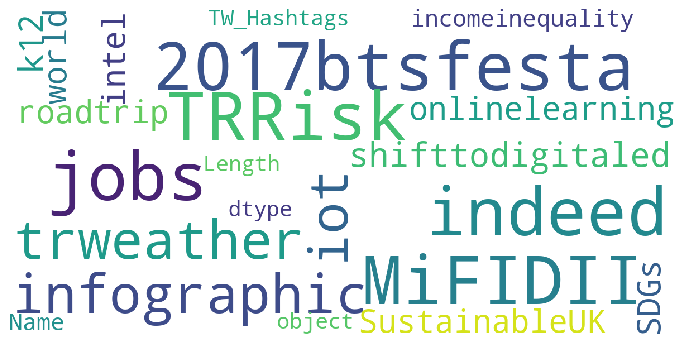

In [10]:
# Show tweet snippet
show_wordcloud(nlp_2["TW_Hashtags"])

## Pre-processing of Snippet
>* The focus of this NLP analysis will be on the Snippet feature which encompasses part of the text of the tweet

In [11]:
# Create a dataframe with all snippets
snippets = nlp_1["Snippet"].astype(str)

In [12]:
# Create a list of strings, where each string is an article title
snippet_list = [snippet for snippet in snippets]

big_list = " ".join(snippet_list)

# Tokenize the string into words
tokens = word_tokenize(big_list)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['anniversary',
 'project',
 'timesquare',
 'thomson',
 'reuters',
 'chinese',
 'youtu',
 'btsfesta',
 'twitter',
 'nearly']

## Definition of the text transformation and word embeding strategy
> * The objective is to transform the text into data which would be manageable for computing and modeling
* I have considered several approaches: Bag of Words (BoW), TF-IDF, Word embeding (e.g. Word2VEc) and more recent learning transfer through Deep Learning (e.g. BERT).
* I have finally decided to select Word2Vec as the word embeding solution. It combined several advantages: it takes into account the context of words, it is a recognized and well documented technique, relevant in the context of this project without being over complex
* I will use a Word2Vec model trained already on the very large corpus of Google News (and most popular social media platforms). The underlying reason is that my text features are based on a general vocabulary (i.e. economic corporate news) which is likely to be relevant within the selected framework of Google News. In the meantime, it offers the opportunity to keep my dataset available for the modeling without having to build-up a specific dictionary required by training a generic Word2Vec model on my dataset.
* It may introduce a bias as the corpus is built around 4 news topics: economy, microsoft, Obama and palestine. There is some literature about Pro's/Con's of this approach. However, it is recognized as a good practice due to its ability to generalize
* As this procedure was not covered in the program, I have leveraged and adapted an appproach published in an article in TowardsDataScience by Charlene Chambliss on this topic: [Link here](https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751)

### Load Word2Vec model trained on the large corpus: GoogleNews (using Gensim library)
* Library documentation: https://radimrehurek.com/gensim/models/keyedvectors.html
* Link to the dataset source: https://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms#

In [13]:
# Load Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(
    "C:/Users/fbaff/Documents/Data Science/Dataset/GoogleNews-vectors-negative300.bin",
    binary=True,
)

In [14]:
# Check dimension of word vectors
model.vector_size

300

In [15]:
economy_vec = model["scientist"]
economy_vec[:20]  # First 20 components

array([ 0.16113281,  0.00473022,  0.3046875 ,  0.18554688,  0.08544922,
        0.5078125 ,  0.03759766, -0.1484375 ,  0.11181641, -0.34960938,
        0.07324219, -0.45117188,  0.02087402, -0.125     , -0.5078125 ,
        0.28515625, -0.10595703,  0.03198242,  0.19335938, -0.27734375],
      dtype=float32)

### Create a dataframe of word vectors of our dataset based on the vocabulary issued from the pre-trained model (GoogleNews voc)

In [16]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient="index")
df.shape

(19182, 300)

In [17]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
anniversary,0.022827,-0.105469,0.205078,0.257812,0.047363,-0.239258,-0.068848,-0.523438,0.777344,0.185547,...,0.178711,-0.353516,-0.275391,-0.080566,0.052979,-0.312500,-0.322266,0.044922,-0.045166,0.143555
project,-0.018066,0.008545,0.069824,0.030762,0.080566,0.034424,0.441406,0.019165,0.011047,0.091309,...,-0.335938,0.045166,-0.110840,0.101562,-0.004578,0.047607,-0.128906,-0.125000,-0.056152,-0.108398
thomson,-0.079590,-0.045654,-0.005280,0.031982,0.055908,0.049316,0.073242,0.016479,-0.029663,-0.000542,...,0.170898,0.063477,-0.011536,0.061035,0.033936,0.055664,-0.038330,-0.019287,-0.063477,0.035645


## Visualize the word embeding using t-SNE dimensionality reduction and conclusions
> * t-SNE is a dimensionality reduction technique more appropriate than PCA for vosualization of high dimensions
* I have focused on 1 hyperparameter: perplexity
* After having tested different values (from 20 to 200), it appears that the effective one for visualization is 50. It is as well a value which is admitted by the community within the standard range of perplexity values (20 to 50)

In [18]:
# Initialize t-SNE
tsne = TSNE(n_components=2, init="random", random_state=10, perplexity=50)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:500])

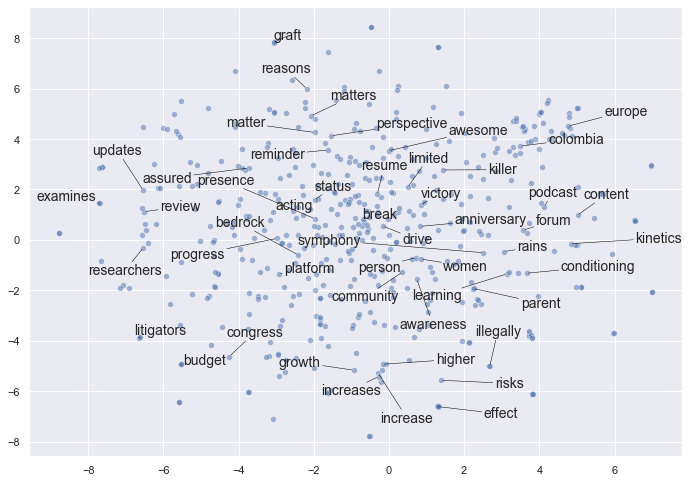

In [19]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha=0.5)

# Second plot: Initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 500, 10))

# Append words to list
for word in words_to_plot:
    texts.append(
        plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize=14)
    )

# Plot text using adjust_text (to avoid text overlaping)
adjust_text(
    texts,
    force_points=0.4,
    force_text=0.4,
    expand_points=(2, 1),
    expand_text=(1, 2),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)

plt.show()

### Conclusions
> * There are different groups which appear to be more distinctive than others:
* **Action related to information**: (left hand side, middle): e.g. examines, up-dates, review
* **Qualification of generic information subject**: (top middle): e.g. matter, reasons, perspective, reminder
* **Legal/regulatory**: (bottom, left): e.g. litigators, congress, budget
* **Qualification of development trends**: (bottom, right): e.g. increase, higher, growth
* **Location**: (top right): e.g. colombia, europe

## Perform snippet embeding via averaging word embeding for each of them

In [20]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)


# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc


# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)


# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus) if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [21]:
# Preprocess the corpus
corpus = [preprocess(title) for title in snippet_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(
    corpus, snippet_list, lambda doc: has_vector_representation(model, doc)
)

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, snippet_list, lambda doc: (len(doc) != 0))

735 docs removed
0 docs removed


In [22]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus:  # append the vector for each document
    x.append(document_vector(model, doc))

X = np.array(x)  # list to array

## Visualize snippet embedding using t-SNE dimensionality reduction
> * Perplexity hyperparameter sets at 40

In [23]:
# Initialize t-SNE
tsne = TSNE(n_components=2, init="random", random_state=10, perplexity=40)

# Use only 500 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:500])

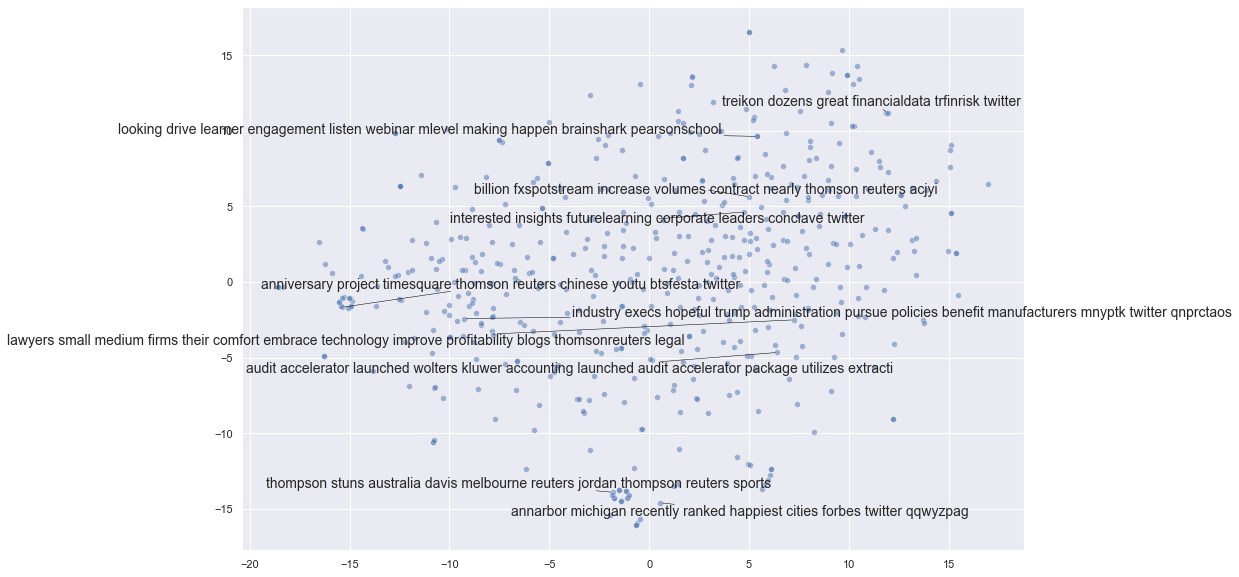

In [24]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha=0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text

texts = []
titles_to_plot = list(
    np.arange(0, 500, 50)
)  # plots every 40th title in first 500 titles

# Append words to list
for title in titles_to_plot:
    texts.append(
        plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize=14)
    )

# Plot text using adjust_text (to avoid text overlaping)
adjust_text(
    texts,
    force_points=0.4,
    force_text=0.4,
    expand_points=(2, 1),
    expand_text=(1, 2),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)

plt.show()

### Conclusions
> * The large % of tweets from/related to Thomson Reuters seems to impact the grouping of word embeddings. We may consider to limit this bias in the modeling phase by fixing an equal number of data points per company to mitigate the risk of unbalance classes
* Nevertheless, there are different groups which appear to be more distinctive than others:
* **Location related**: (bottom): e.g. Melbourne, Michigan
* **Regulatory/policies topics**: (middle): e.g. policies, legal, accounting

## Consolidate document embedding vectors with features processed/engineered during the EDA step

### Create a csv file combining document embedding and processed/enginnered features from the EDA

In [25]:
# Create a dataframe with full document embedding and the dataframe resulting from the EDA process
df_all_vectors = pd.DataFrame(x)

df_all_vectors["Title"] = titles_list

main_all_vectors = pd.concat((df_all_vectors, twitter_nlp), axis=1)

# Get rid of vectors that couldn't be matched with the original dataframe
main_all_vectors.dropna(axis=0, inplace=True)

main_all_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,ALL_Impact,Log_TW_KredOutreach,Log_Nbreach,Log_TW_NbFollowers,Log_TW_NbFollowing,Log_TW_NbTweets,Snippet,TW_Hashtags,ALL_Author,TW_Account_Name
0,-0.043355,-0.026154,0.056330,0.096232,-0.079631,-0.052836,0.048258,-0.210815,0.129344,0.028728,...,28,0.0,6.052089,4.043051,5.093750,7.409136,anniversary project timesquare thomson reuters...,2017btsfesta,titina_joner,tw account not identified
1,0.062174,-0.016751,0.080119,0.042372,-0.120394,-0.103285,-0.096608,-0.039890,0.037337,-0.032766,...,25,0.0,5.940171,3.295837,4.948760,8.307706,nearly canadians deport people illegally cross...,No TW hashtag,dasCameo1,tw account not identified
2,-0.005493,-0.046224,-0.041031,0.039266,-0.156698,0.102946,0.091634,-0.114136,0.035787,0.029237,...,25,0.0,5.921578,3.135494,0.000000,12.286371,support associate thomson reuters carrollton i...,"indeed, jobs",lumpyspace_tst2,tw account not identified
3,0.034058,-0.047404,0.014119,-0.056559,-0.054515,-0.006490,-0.003326,-0.080485,0.138346,-0.030263,...,64,0.0,7.832808,6.736967,5.043425,4.564348,mifidii compliance challenge mifidii ready ana...,"MiFIDII, TRRisk",mifidii,tw account not identified
4,0.015451,0.072963,-0.063298,0.152832,0.010882,-0.013000,0.053467,-0.033273,0.140869,0.007952,...,41,0.0,6.408529,7.094235,7.222566,8.832150,challenges implementing insurance projects imp...,"infographic, iot",daviddefelipe,david de felipe


In [26]:
main_all_vectors.shape

(194484, 351)

In [27]:
# Create a csv file
# main_all_vectors.to_csv('master_modeling.csv')